In [54]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import pandas as pd

In [55]:
df = pd.read_csv("obat_alodokter_new.csv")
df.head()
df_obat_for_eval = df.drop(['nama_obat'],axis=1)

In [56]:
import re

def clean_text(text):
    text = re.sub(r'\n+', ' ', text)  # hapus banyak \n
    text = re.sub(r'\s+', ' ', text)   # hapus spasi berlebihan
    return text.strip()

df['cleaned_reference'] = df['content'].apply(clean_text)

df['generated_text'] = df['cleaned_reference'].apply(lambda x: x.lower())

In [57]:
df_obat_for_bleu = df.drop(['nama_obat','generated_text','content'],axis=1)
df_obat_for_ndcg = df.drop(['generated_text','content'],axis=1)

In [58]:
df_obat_for_bleu

,cleaned_reference
0,Zyloric Zyloric adalah obat untuk menurunkan k...
1,Zovirax Krim Zovirax krim adalah obat oles yan...
2,Zovigen Zovigen adalah obat oles yang bermanfa...
3,Zoralin Krim Zoralin krim adalah obat oles unt...
4,Zoralin Zoralin adalah tablet antijamur berbah...
...,...
2168,Acarbose Acarbose adalah obat untuk menurunkan...
2169,Acalabrutinib Acalabrutinib adalah obat kemote...
2170,Abrocitinib Abrocitinib adalah obat untuk meng...
2171,Abemaciclib Abemaciclib adalah obat kemoterapi...


In [59]:
df_obat_for_ndcg

,nama_obat,cleaned_reference
0,Zyloric,Zyloric Zyloric adalah obat untuk menurunkan k...
1,Zovirax Krim,Zovirax Krim Zovirax krim adalah obat oles yan...
2,Zovigen,Zovigen Zovigen adalah obat oles yang bermanfa...
3,Zoralin Krim,Zoralin Krim Zoralin krim adalah obat oles unt...
4,Zoralin,Zoralin Zoralin adalah tablet antijamur berbah...
...,...,...
2168,Acarbose,Acarbose Acarbose adalah obat untuk menurunkan...
2169,Acalabrutinib,Acalabrutinib Acalabrutinib adalah obat kemote...
2170,Abrocitinib,Abrocitinib Abrocitinib adalah obat untuk meng...
2171,Abemaciclib,Abemaciclib Abemaciclib adalah obat kemoterapi...


In [60]:
import pandas as pd
import json

def format_result_to_text(user_data):
    formatted_text = ""
    for idx, record in enumerate(user_data['agent']):
        nomor = idx + 1  
        formatted_text += f"{nomor}. Rekomendasi obat:\n"
        formatted_text += f" - {record.get('nama_obat')} Dosis: {record.get('dosis')}\n"
        formatted_text += f"   Aturan pakai: {record.get('aturan_pakai', 'Aturan Pakai Tidak Tersedia')}\n"
        formatted_text += f"   Efek samping: {record.get('efek_samping_obat', 'Efek Samping Tidak Tersedia')}\n\n"
    return formatted_text.strip()

with open('memory.json', 'r') as file:
    data = json.load(file)

df_obat_for_bleu = pd.DataFrame({
    'generated_text': [None] * 4 
})

user_id = "7116300622"
if user_id in data:
    user_data = data[user_id][0] 
    formatted_text = format_result_to_text(user_data)
    
    df_obat_for_bleu.loc[0, 'generated_text'] = formatted_text


In [61]:
bleu_scores = []
rouge_scores = []

rouge = Rouge()

In [62]:
for idx, row in df.iterrows():
    reference = [row['cleaned_reference'].split()]  # list of list
    candidate = row['generated_text'].split()

    # Hitung BLEU
    bleu = sentence_bleu(reference, candidate)
    bleu_scores.append(bleu)

    # Hitung ROUGE
    rouge_score = rouge.get_scores(row['generated_text'], row['cleaned_reference'])[0]
    rouge_scores.append(rouge_score)

# Rata-rata skor
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_rouge_1 = sum([r['rouge-1']['f'] for r in rouge_scores]) / len(rouge_scores)
avg_rouge_2 = sum([r['rouge-2']['f'] for r in rouge_scores]) / len(rouge_scores)
avg_rouge_l = sum([r['rouge-l']['f'] for r in rouge_scores]) / len(rouge_scores)

print("Average BLEU:", avg_bleu)
print("Average ROUGE-1:", avg_rouge_1)
print("Average ROUGE-2:", avg_rouge_2)
print("Average ROUGE-L:", avg_rouge_l)

Average BLEU: 0.6563175584020436
Average ROUGE-1: 0.8320645836767182
Average ROUGE-2: 0.710628568721906
Average ROUGE-L: 0.8320645836767182


In [63]:
import math

def dcg(relevances):
    return sum((rel / math.log2(i + 2)) for i, rel in enumerate(relevances))

def compute_ndcg_at_k(true_relevant, recommended_items, k=5):
    recommended_items_k = recommended_items[:k]

    relevance_scores = [1 if item in true_relevant else 0 for item in recommended_items_k]

    actual_dcg = dcg(relevance_scores)

    ideal_relevance = sorted(relevance_scores, reverse=True)
    ideal_dcg = dcg(ideal_relevance)

    if ideal_dcg == 0:
        return 0.0

    return actual_dcg / ideal_dcg

In [64]:
true_relevant = ['Loratadine', 'Cetirizine', 'Alloris','Lerzin','Claritin','Incidal'] 
recommended_items = ['Cetirizine', 'Loratadine', 'Prednison', 'Diphenhydramine', 'Hydroxyzine'] 
ndcg_score = compute_ndcg_at_k(true_relevant, recommended_items, k=5)

print(f'NDCG Score (Penyakit Biduran): {ndcg_score}')

# True Relevant are from : https://www.halodoc.com/artikel/ini-7-rekomendasi-obat-biduran-yang-ampuh-redakan-gatal-pada-kulit?srsltid=AfmBOop_TdeE3_w0hvmboT2MaqozctxPiEfYttqcFtmR82yZn_utLuc9

NDCG Score (Penyakit Biduran): 1.0


In [65]:
true_relevant = ['Isoniazid', 'Rifampicin', 'Pro TB-4','Pro TB-2','Pyrazinamide'] 
recommended_items = ['Rifampicin', 'Isoniazid', 'Pyrazinamide', 'Ethambutol', 'Streptomisin'] 
ndcg_score = compute_ndcg_at_k(true_relevant, recommended_items, k=5)

print(f'NDCG Score (Penyakit TBC): {ndcg_score}')

# True Relevant are from : https://www.halodoc.com/artikel/ini-5-rekomendasi-obat-tbc-paling-ampuh-di-apotek?srsltid=AfmBOoriugcRH8mkDix6JTJHlcJZrQtnA1ATLKQGkXAWfcS9S0envryI

NDCG Score (Penyakit TBC): 1.0


In [66]:
true_relevant = ['Warfarin', 'Rivaroxaban', 'Dabigatran','Apixaban','Edoxaban','Heparin'] 
recommended_items = ['Heparin', 'Warfarin', 'Edoxaban', 'Enoxaparin', 'Rivaroxaban'] 
ndcg_score = compute_ndcg_at_k(true_relevant, recommended_items, k=5)

print(f'NDCG Score (Penyakit Emboli Paru): {ndcg_score}')

# True Relevant are from : https://hellosehat.com/pernapasan/emboli-paru/obat-emboli-paru/

NDCG Score (Penyakit Emboli Paru): 0.9828920819566879


In [67]:
true_relevant = ['Olopatadine', 'Azelastin', 'Ketotifen','Dekongestan'] 
recommended_items = ['Olopatadine', 'Cetirizine', 'Loratadine', 'saline', 'Antazoline'] 
ndcg_score = compute_ndcg_at_k(true_relevant, recommended_items, k=5)

print(f'NDCG Score (Penyakit Alergi Mata): {ndcg_score}')

# True Relevant are from : https://hellosehat.com/alergi/hidung-dan-mata/obat-alergi-mata/

NDCG Score (Penyakit Alergi Mata): 1.0


In [68]:
true_relevant = ['Besi elemental (garam besi)', 'Ferrous Sulfate', 'Ferrous Fumarate','Ferrous Gluconate','Heme iron polypeptide','Iron polysaccharide'] 
recommended_items = ['Ferrous Sulfate', 'Ferrous Gluconate', 'Ferrous Fumarate', 'Iron Sucrose', 'Polysaccharide Iron Complex'] 
ndcg_score = compute_ndcg_at_k(true_relevant, recommended_items, k=5)

print(f'NDCG Score (Penyakit Anemia defisiensi besi): {ndcg_score}')

# True Relevant are from : https://www.alomedika.com/penyakit/hematologi/anemia-defisiensi-besi/penatalaksanaan

NDCG Score (Penyakit Anemia defisiensi besi): 1.0


In [69]:
def f1_score_rag(pred, true):
    pred_tokens = pred.lower().split()
    true_tokens = true.lower().split()

    common = set(pred_tokens) & set(true_tokens)
    if not common:
        return 0.0

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return f1

generated_answer = 'Modafinil diambil sesuai dosis yang diresepkan dokter tergantung kondisi pasien. Pastikan untuk mengikuti instruksi serta waktu dan cara penggunaan yang tepat.'
ground_truth_answer = 'Dosis modafinil yang diresepkan dokter dapat berbeda pada tiap pasien. Berikut ini adalah dosis umum penggunaan modafinil berdasarkan kondisi pasien'

f1_score = f1_score_rag(generated_answer, ground_truth_answer)

print("F1 Score:",f1_score)

F1 Score: 0.3902439024390244


In [70]:
scores = {
    "Bleu" : avg_bleu,
    "Rouge-1" : avg_rouge_1,
    "Rouge-2" : avg_rouge_2,
    "Rouge-L" : avg_rouge_l,
    "F1-Score" : f1_score,
    "NDCG" : ndcg_score
}

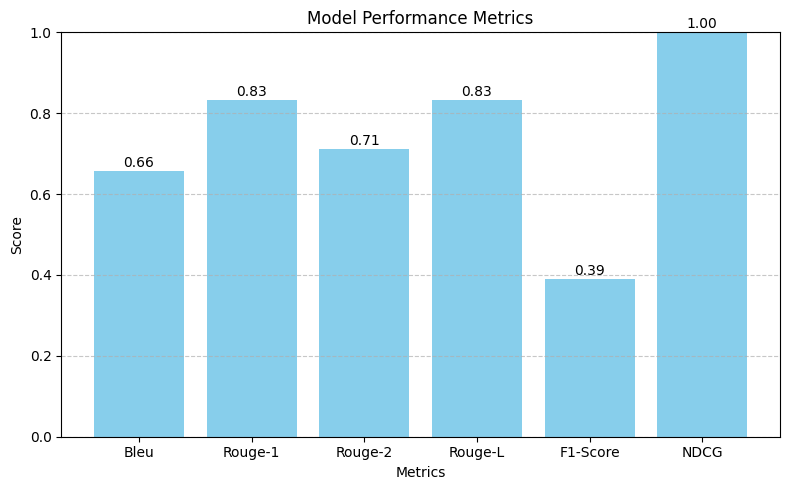

In [71]:
import matplotlib.pyplot as plt

# Data
metrics = list(scores.keys())
values = list(scores.values())

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color='skyblue')

# Tambahkan nilai di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center')

# Label dan judul
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
